In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## strange error only on macOS apparently 
## https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
## get data, just Close values
import readcsv
data_raw = readcsv.get_data(cols=['Close'], verbose=False).astype(np.float32)
print(data_raw.shape)

(18628, 54)


In [3]:
## scale all data into interval [0, 1]
import sklearn.preprocessing
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(data_raw)
data_raw = scaler.transform(data_raw)

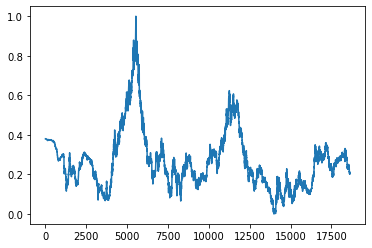

In [4]:
## visualize data, just to make sure things are OK
plt.plot(data_raw[:, 0])
plt.show()

In [5]:
## test: fit on cosine
#data = np.cos(2*np.pi*np.arange(18000)/25).reshape(-1, 1)
#print(data.shape)

In [6]:
from rnn_helper import *
#test_rnn_helper()

# Predict next day
Given 30-day history of USD-EUR closing, predict next day closing price.
Should expect good performance since linear regression is pretty good at this.

In [7]:
## ===== learning parameters ========================
learn_window = np.arange(30) ## learn from past 30 days
predict_window = np.arange(1) ## predict next day
## ==================================================

In [8]:
## split into training and testing sets
## take 100 random windows, 50 for validation and 50 for testing
## all other non-overlapping data goes to testing.

data = data_raw[:, 0:1] ## take only USD-EUR Close values
print("Data shape:", data.shape)

N, C = data.shape
L, P = len(learn_window), len(predict_window)
Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
M = N - Lcap - Pcap

np.random.seed(999)
test_starts = np.random.randint(0, M, 50)
val_starts = np.random.randint(0, M, 50)

mask = np.ones(N)
for i in test_starts:
    mask[i+learn_window] = 0
for i in val_starts:
    mask[i+learn_window] = 0 
mask[np.arange(M, N)] = 0
train_starts = np.flatnonzero(mask)

print("Training size:", train_starts.shape[0])
print("Validation size:", val_starts.shape[0], "...", val_starts[:5])
print("Test size:", test_starts.shape[0], "...", test_starts[:5])

Data shape: (18628, 1)
Training size: 15747
Validation size: 50 ... [ 1286  7103  9451 16503 13300]
Test size: 50 ... [12636 13157 16865  5832  8417]


In [9]:
## generate testing and validation data
G = generate_all_regression(data, 50, learn_window, predict_window, val_starts)
X_val, y_val = next(G)

G = generate_all_regression(data, 50, learn_window, predict_window, test_starts)
X_test, y_test = next(G)

In [10]:
## ===== model hyperparameters ======================
batch_size = 50
initial_learning_rate = 1e-3
decay_steps = 300
decay_rate = 0.9
## ==================================================

np.random.seed(0) ## for reproducability
tf.random.set_seed(0)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model_1d = models.Sequential()
#model_1d.add(layers.LSTM(100, input_shape=(L, C)))
model_1d.add(layers.GRU(200, input_shape=(L, C)))
model_1d.add(layers.Dense(P))
model_1d.compile(optimizer=opt, loss='mse')
model_1d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 200)               121800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________


In [11]:
## train on one data point as test
G = generate_batches_regression(data, 1, learn_window, predict_window, train_starts)
X, y = next(G)

model_1d.fit(X, y, batch_size=1)
model_1d.evaluate(X, y, batch_size=1)

Train on 1 samples
1/1 [==============================] - 1s 1s/sample - loss: 0.0214


0.02144799940288067

In [46]:
## train!
G = generate_batches_regression(data, batch_size, learn_window, predict_window, train_starts)

## GRU
#model_1d.fit(G, steps_per_epoch=300, epochs=30, validation_data=(X_val, y_val))
## LSTM
model_1d.fit(G, steps_per_epoch=300, epochs=50, validation_data=(X_val, y_val))

Train for 300 steps, validate on 50 samples
Epoch 1/50
300/300 [==============================] - 39s 130ms/step - loss: 0.0014 - val_loss: 1.6249e-04
Epoch 2/50
300/300 [==============================] - 33s 109ms/step - loss: 1.1474e-04 - val_loss: 1.4012e-04
Epoch 3/50
300/300 [==============================] - 31s 104ms/step - loss: 1.0701e-04 - val_loss: 1.3343e-04
Epoch 4/50
300/300 [==============================] - 33s 109ms/step - loss: 9.3832e-05 - val_loss: 1.2945e-04
Epoch 5/50
300/300 [==============================] - 33s 111ms/step - loss: 9.2366e-05 - val_loss: 1.2402e-04
Epoch 6/50
300/300 [==============================] - 34s 115ms/step - loss: 8.2225e-05 - val_loss: 1.1815e-04
Epoch 7/50
300/300 [==============================] - 38s 126ms/step - loss: 7.9402e-05 - val_loss: 9.9102e-05
Epoch 8/50
300/300 [==============================] - 35s 118ms/step - loss: 7.1275e-05 - val_loss: 8.8471e-05
Epoch 9/50
300/300 [==============================] - 35s 115ms/step - l

Comment for GRU: The validation loss is slightly less than training loss. This is because since our dataset is non-uniform in time, the training data is just harder to model than the validation data. At least, this assures us that our model is not overfitting. Also, the training loss is a running average over the epoch, so it is over-estimated in the beginning.

Comment for LSTM: takes more epochs to train

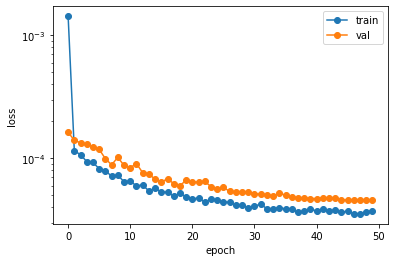

In [47]:
train_loss = model_1d.history.history['loss']
val_loss = model_1d.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

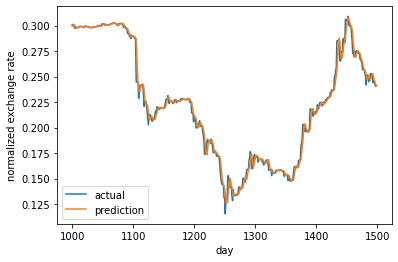

In [48]:
## visualize predictions
starts = np.arange(1000, 1500)

G = generate_all_regression(data, len(starts), learn_window, predict_window, starts)
X, y_actual = next(G)
y_predict = model_1d.predict(X)

plt.plot(dates, y_actual[:, 0], label='actual')
plt.plot(dates, y_predict[:, 0], label='prediction')
plt.ylabel('normalized exchange rate')
plt.xlabel('day')
plt.legend()
plt.show()

In [49]:
y = model_1d.predict(X_test)
ave_mse = np.mean(np.square(y_test - y))
scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
ave_mse *= scale_factor
print("Average MSE on testing data: %.3e" % ave_mse)

Average MSE on testing data: 2.831e-05


**Average MSE on testing data for next day predictions.**

- Linear regression (slope on 5d): 3.6e-5
- LSTM (100 units): 2.8e-5
- GRU (100 units): 2.4e-5

# Predict future trend
Given 100-day USD-EUR closing, predict next 30-days. Try to beat linear regression predictions

In [7]:
## ===== learning parameters ========================
learn_window = np.arange(100) ## learn from past 100 days
predict_window = np.arange(0, 30, 3) ## predict next 30 days, sampled 10 times
## ==================================================

In [8]:
## split into training and testing sets
## take 100 random windows, 50 for validation and 50 for testing
## all other non-overlapping data goes to testing.

#data = data_raw[:, 0:1] ## take only USD-EUR Close values
data = data_raw[:, [0, 15, 16, 17, 18]] ## take all currencies
print("Data shape:", data.shape)

N, C = data.shape
L, P = len(learn_window), len(predict_window)
Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
M = N - Lcap - Pcap

np.random.seed(999)
test_starts = np.random.randint(0, M, 50)
val_starts = np.random.randint(0, M, 50)

mask = np.ones(N)
for i in test_starts:
    mask[i+learn_window] = 0
for i in val_starts:
    mask[i+learn_window] = 0 
mask[np.arange(M, N)] = 0
train_starts = np.flatnonzero(mask)

print("Training size:", train_starts.shape[0])
print("Validation size:", val_starts.shape[0], "...", val_starts[:5])
print("Test size:", test_starts.shape[0], "...", test_starts[:5])

Data shape: (18628, 5)
Training size: 10759
Validation size: 50 ... [ 1286  7103  9451 16503 13300]
Test size: 50 ... [12636 13157 16865  5832  8417]


In [9]:
## generate testing and validation data
G = generate_all_regression(data, 50, learn_window, predict_window, val_starts)
X_val, y_val = next(G)

G = generate_all_regression(data, 50, learn_window, predict_window, test_starts)
X_test, y_test = next(G)

print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(50, 100, 5)
(50, 10)
(50, 100, 5)
(50, 10)


In [10]:
## ===== model hyperparameters ======================
batch_size = 50
initial_learning_rate = 1e-3
decay_steps = 300
decay_rate = 0.9
## ==================================================

np.random.seed(1) ## for reproducability
tf.random.set_seed(1)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)

model_trend = models.Sequential()
model_trend.add(layers.GRU(100, return_sequences=True, input_shape=(L, C),
                          dropout=.1, recurrent_dropout=.1))
model_trend.add(layers.GRU(100, return_sequences=True,
                          dropout=.1, recurrent_dropout=.1))
model_trend.add(layers.GRU(100, dropout=.1, recurrent_dropout=.1))
model_trend.add(layers.Dense(P))
model_trend.compile(optimizer=opt, loss='mse')
model_trend.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100, 100)          32100     
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 100)          60600     
_________________________________________________________________
gru_2 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
Total params: 154,310
Trainable params: 154,310
Non-trainable params: 0
_________________________________________________________________


In [49]:
## reduce all input weights not accociated with USD-EUR to 0
#weights = model_trend.layers[0].get_weights()
#weights[0][1:] /= 100.
#model_trend.layers[0].set_weights(weights)

In [11]:
## train on one data point as test
G = generate_batches_regression(data, 1, learn_window, predict_window, train_starts)
X, y = next(G)

model_trend.fit(X, y, batch_size=1)
model_trend.evaluate(X, y, batch_size=1)

Train on 1 samples
1/1 [==============================] - 2s 2s/sample - loss: 0.4577


0.45768141746520996

In [12]:
## train!
G = generate_batches_regression(data, batch_size, learn_window, predict_window, train_starts)

## GRU, only exchange rate
model_trend.fit(G, steps_per_epoch=300, epochs=30, validation_data=(X_val, y_val))
## LSTM
#model_trend.fit(G, steps_per_epoch=300, epochs=50, validation_data=(X_val, y_val))

Train for 300 steps, validate on 50 samples
Epoch 1/30
300/300 [==============================] - 355s 1s/step - loss: 0.0063 - val_loss: 0.0073
Epoch 2/30
300/300 [==============================] - 351s 1s/step - loss: 0.0059 - val_loss: 0.0049
Epoch 3/30
300/300 [==============================] - 351s 1s/step - loss: 0.0212 - val_loss: 0.0048
Epoch 4/30
300/300 [==============================] - 419s 1s/step - loss: 0.0047 - val_loss: 0.0044
Epoch 5/30
300/300 [==============================] - 391s 1s/step - loss: 0.0044 - val_loss: 0.0039
Epoch 6/30
300/300 [==============================] - 410s 1s/step - loss: 0.0041 - val_loss: 0.0038
Epoch 7/30
300/300 [==============================] - 424s 1s/step - loss: 0.0041 - val_loss: 0.0032
Epoch 8/30
300/300 [==============================] - 375s 1s/step - loss: 0.0040 - val_loss: 0.0030
Epoch 9/30
300/300 [==============================] - 448s 1s/step - loss: 0.0029 - val_loss: 0.0024
Epoch 10/30
300/300 [==========================

KeyboardInterrupt: 

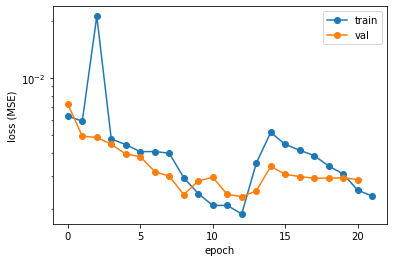

In [13]:
train_loss = model_trend.history.history['loss']
val_loss = model_trend.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

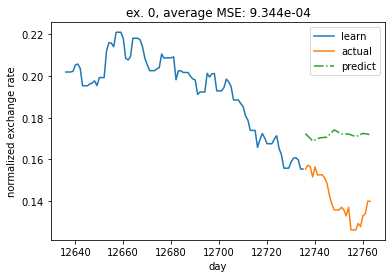

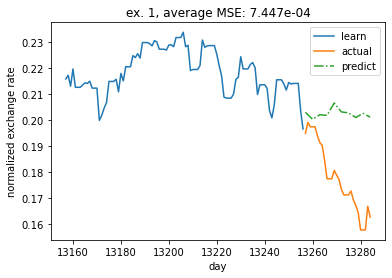

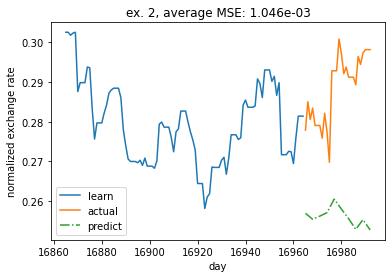

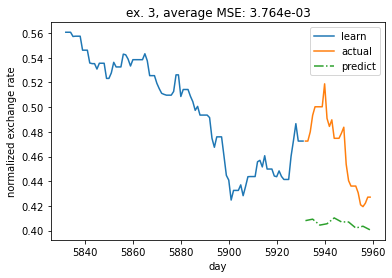

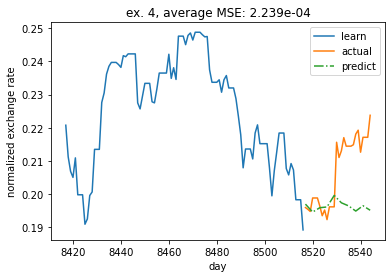

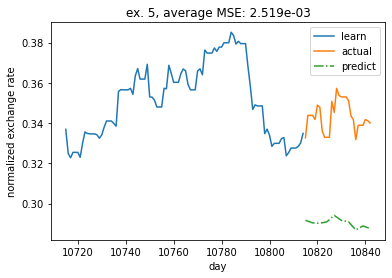

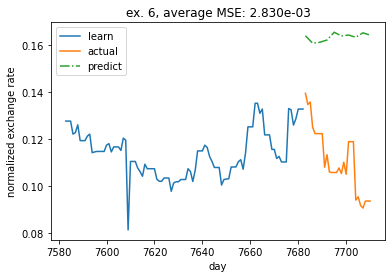

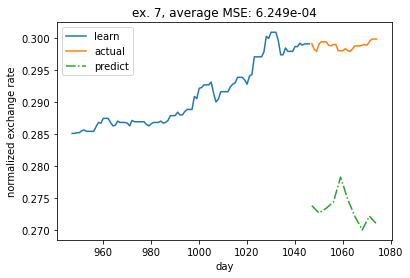

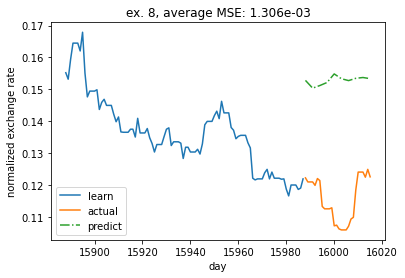

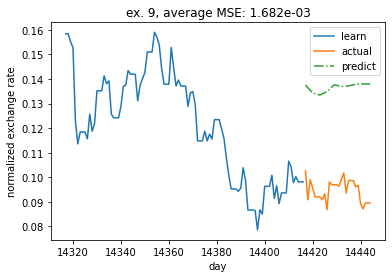

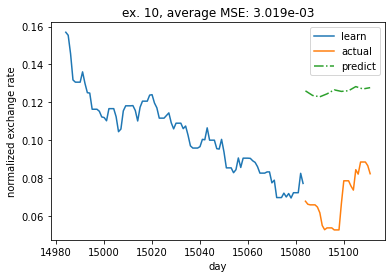

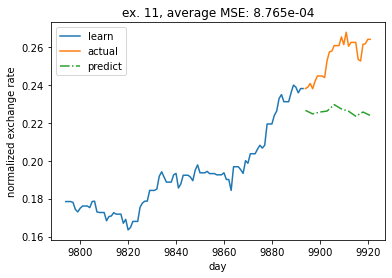

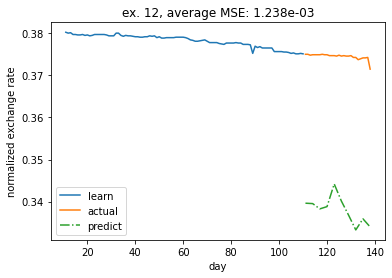

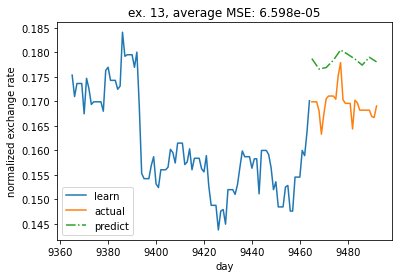

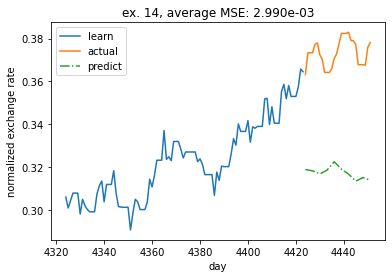

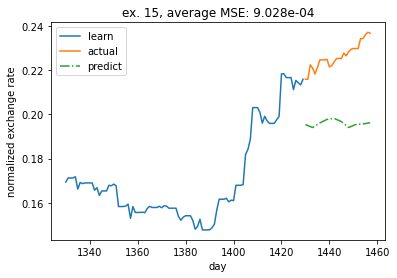

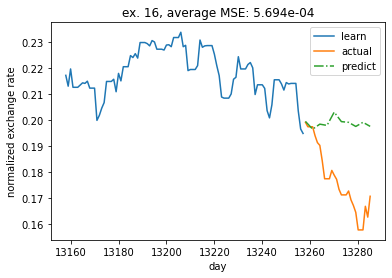

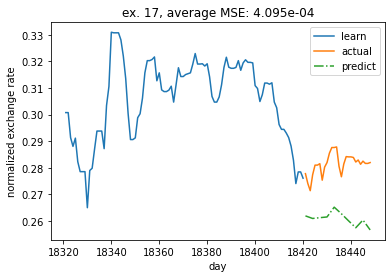

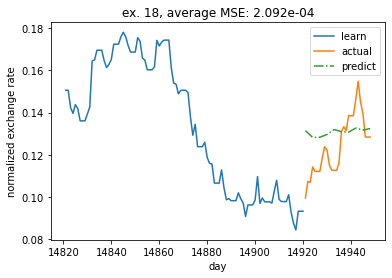

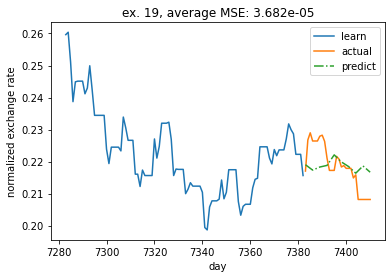

In [14]:
## visualize predictions
actual_window = np.arange(Pcap)

G = generate_all_regression(data, 1, learn_window, predict_window, test_starts)
for count, i in enumerate(test_starts):
    
    if count==20:
        break
    
    X, y = next(G)
    
    x_learn = i+learn_window
    x_actual = i+Lcap+actual_window
    
    y_learn = data[x_learn, 0]
    y_actual = data[x_actual, 0]
    
    y_predict = model_trend.predict(X)
    
    mse = np.mean(np.square(y[0] - y_predict[0]))
    scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
    mse *= scale_factor
    
    plt.plot(x_learn, y_learn, label='learn')
    plt.plot(x_actual, y_actual, label='actual')
    plt.plot(x_actual[predict_window], y_predict[0], '-.', label='predict')
    plt.title('ex. %d, average MSE: %.3e' % (count, mse))
    plt.ylabel('normalized exchange rate')
    plt.xlabel('day')
    plt.legend()
    plt.show()

In [15]:
y = model_trend.predict(X_test)
ave_mse = np.mean(np.square(y_test - y))
scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
ave_mse *= scale_factor
print("Average MSE on testing data: %.3e" % ave_mse)

Average MSE on testing data: 1.259e-03


In [16]:
in_weight = model_trend.layers[0].get_weights()[0]
a = np.max(np.abs(in_weight), axis=1)
print(a)
print(np.argsort(a))

[0.28015828 0.306949   0.36463046 0.18651408 0.23285232]
[3 4 0 1 2]


Seems that model just predicts a straight line. While this loss is technically lower than that of linear regression, I don't think the model is learning anything meaningful.

**Average MSE on testing data for 30-day predictions.**

- Linear regression (slope on 30d): 5.5e-4
- GRU (100-100-100 units, dropout, only exchange rate): 2.5e-4